In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/scripts/Mixture + Analytes/3 Analytes/')

from utils import add_noise, plot_lda_decision_boundary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle
import re

import warnings
warnings.filterwarnings('ignore')
os.chdir('/home/soham/Desktop/GitHub/BTP/')

In [2]:
total_data = pd.read_csv('data/smote/labelled.csv')
total_data.head()

,CFU/mL,Sensor2,Sensor1,Sensor3,label
0,30500000.0,70.734,-68.02,52.47,1
1,3050000.0,50.162,-95.70,32.63,1
2,305000.0,-8.390,-99.96,-10.41,1
3,30500.0,-18.700,-107.42,-23.93,1
4,3050.0,-19.620,-109.94,-27.24,1


### LDA

In [3]:
total_data = total_data.drop(['CFU/mL'], axis=1)
labels = total_data['label']

total_data.head()

,Sensor2,Sensor1,Sensor3,label
0,70.734,-68.02,52.47,1
1,50.162,-95.70,32.63,1
2,-8.390,-99.96,-10.41,1
3,-18.700,-107.42,-23.93,1
4,-19.620,-109.94,-27.24,1


In [4]:
X = total_data[['Sensor1','Sensor2','Sensor3']]
Y = total_data['label']
label_mapping = {1: 'A1', 2: 'A2', 3: 'A3'}

lda  = LDA(n_components=2)
lda.fit(X, Y)
lda_data = lda.transform(X)
lda_data = pd.DataFrame(lda_data, columns=['LD1', 'LD2'])

X_train, X_test, Y_train, Y_test = train_test_split(lda_data, Y, test_size=0.3, random_state=np.random.randint(0,100))

lda_data.head()

,LD1,LD2
0,2.456308,0.187665
1,2.525109,-0.008283
2,0.848656,-0.537219
3,0.858842,-0.746391
4,0.957490,-0.808189


### SVM

In [5]:
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)

print('Training accuracy = ', svm.score(X_train, Y_train))

pred = svm.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))

pickle.dump(svm, open('models/3 solutions/lda_svm.pkl', 'wb'))

Training accuracy =  1.0
Testing accuracy =  1.0


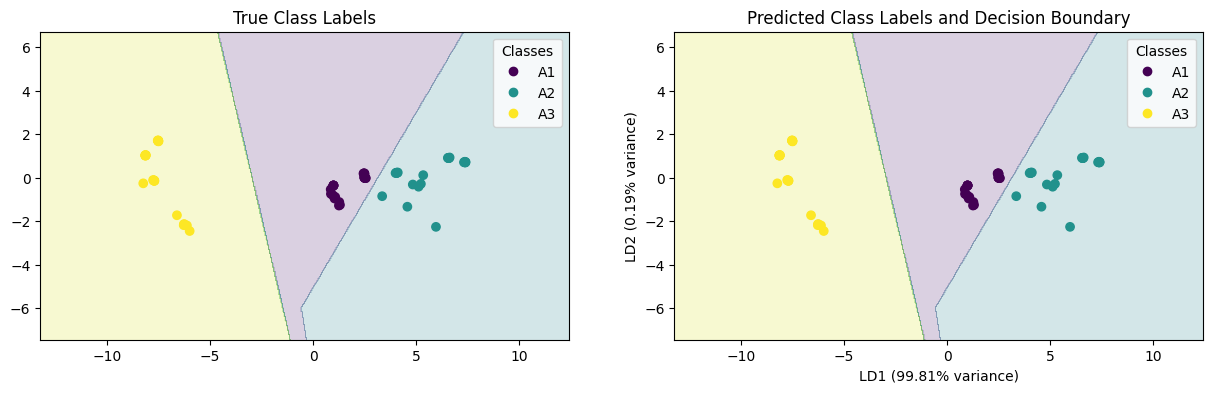

In [6]:
lda_data['Labels'] = total_data['label'].map(label_mapping)
plot_lda_decision_boundary(lda, lda_data, svm, label_mapping)

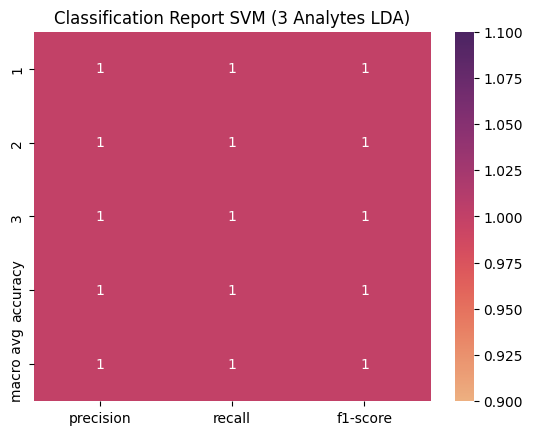

In [7]:
''' Confusion matrix '''

predictions = svm.predict(lda_data[['LD1','LD2']])
report = classification_report(predictions, Y, output_dict=True)
report = pd.DataFrame(report).transpose()

sns.heatmap(report.iloc[:-1, :-1], annot=True, cmap='flare')
plt.title('Classification Report SVM (3 Analytes LDA)')
plt.show()

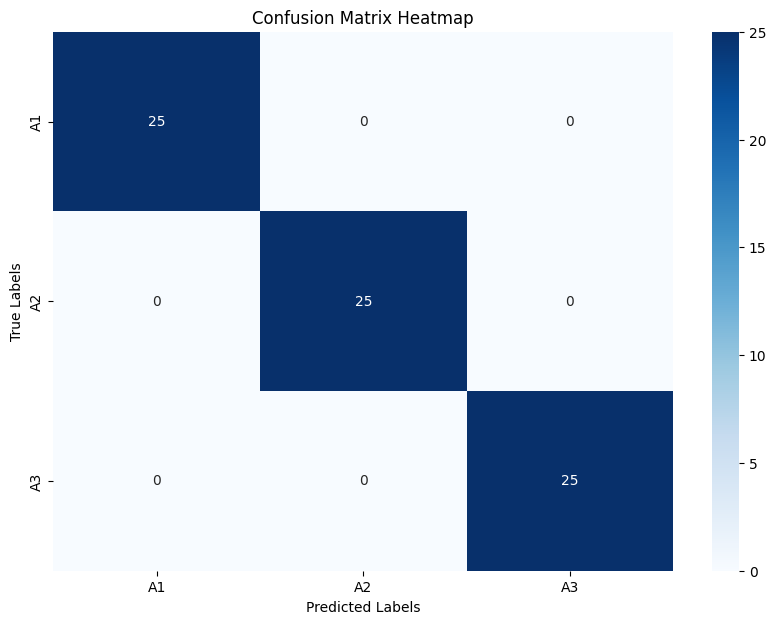

In [8]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y, predictions)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Adding Additional Noise Points

Noise Level: 0.05
Training accuracy =  1.0
Testing accuracy =  1.0


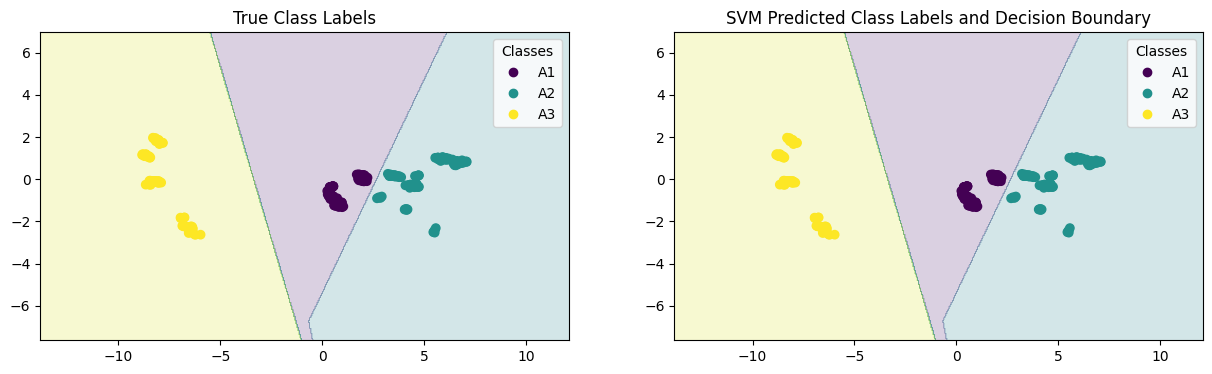

Noise Level: 0.1
Training accuracy =  1.0
Testing accuracy =  1.0


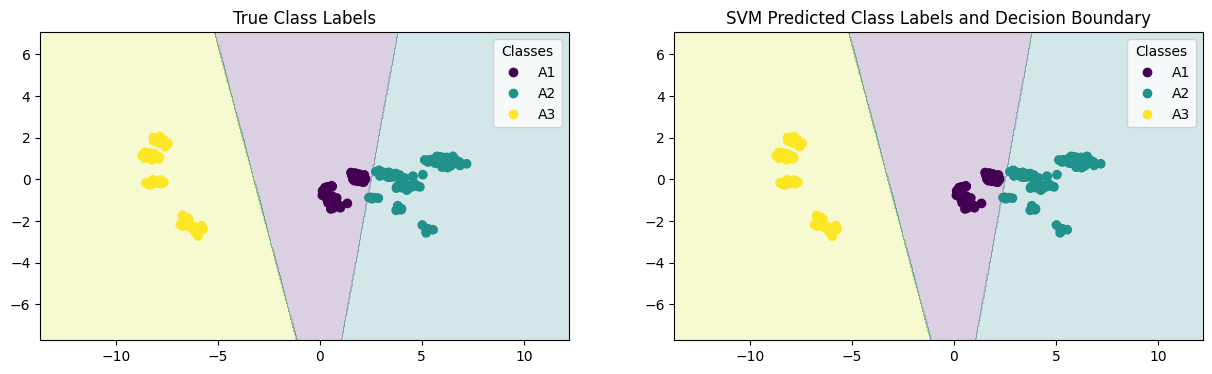

Noise Level: 0.15
Training accuracy =  0.9857142857142858
Testing accuracy =  1.0


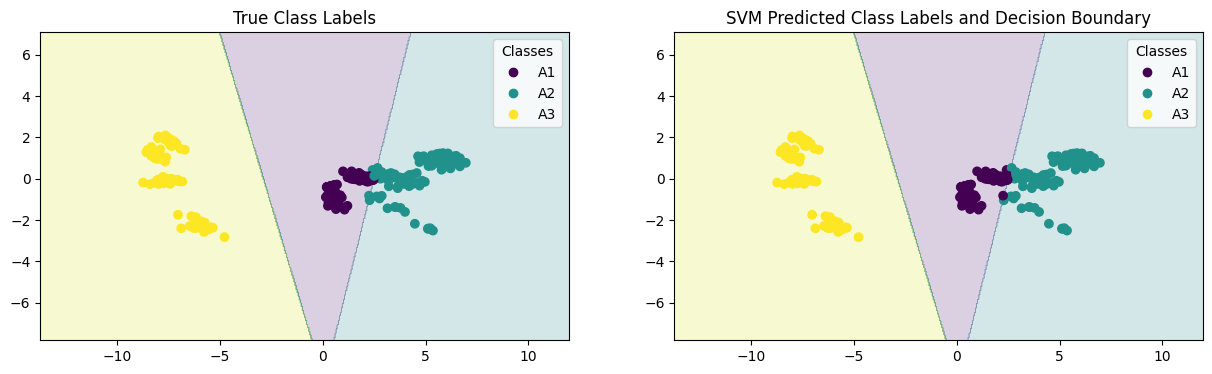

Noise Level: 0.2
Training accuracy =  0.9964285714285714
Testing accuracy =  0.9714285714285714


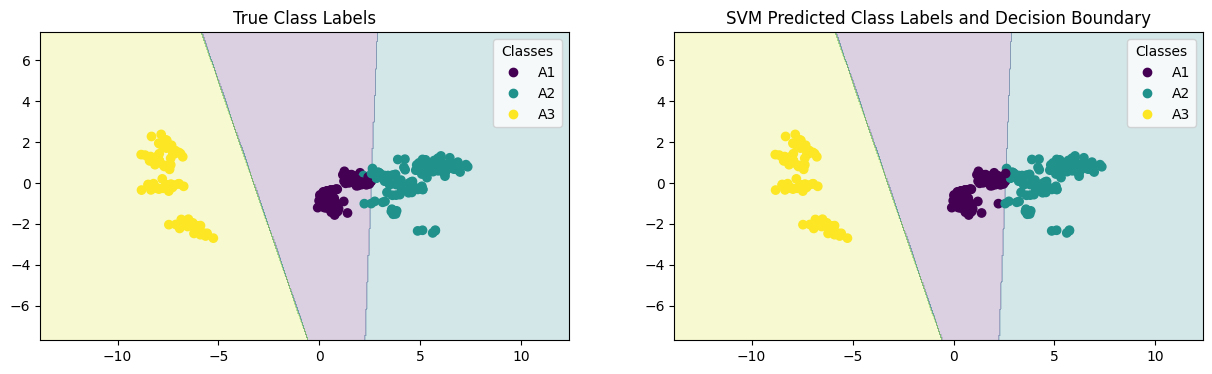

Noise Level: 0.25
Training accuracy =  0.9642857142857143
Testing accuracy =  0.9857142857142858


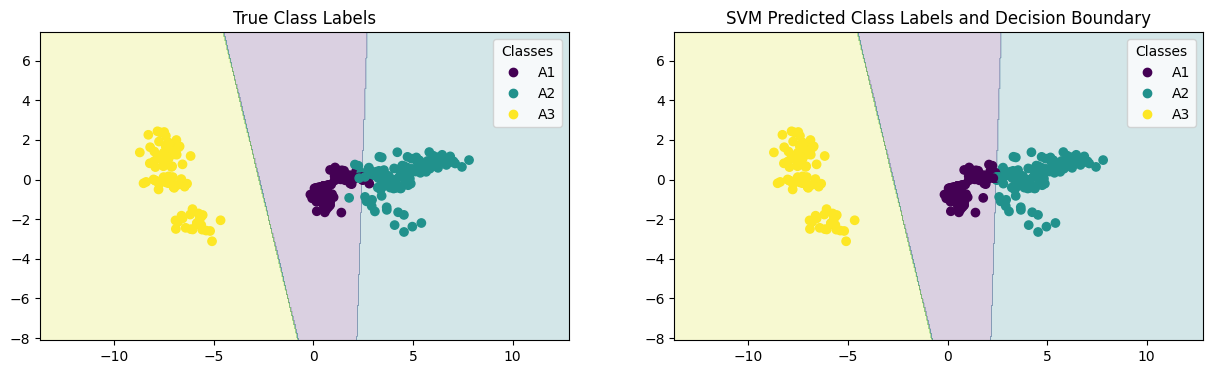

In [12]:
for p in [0.05, 0.10, 0.15, 0.2, 0.25]:

    # Adding noise to the data

    print(f'Noise Level: {p}')
    data_noisy, noisy_labels = add_noise(total_data[['Sensor1', 'Sensor2', 'Sensor3']], total_data['label'], p)


    lda = LDA(n_components=2)
    lda_data = lda.fit_transform(data_noisy, noisy_labels)
    lda_data = pd.DataFrame(lda_data, columns=['LD1','LD2'])
    lda_data['label'] = noisy_labels


    # Split into training and testing data

    Y = lda_data['label']
    X = lda_data.drop(['label'], axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0,100))

    svm = SVC(kernel='linear')
    svm.fit(X_train, Y_train)
    print('Training accuracy = ', svm.score(X_train, Y_train))

    pred = svm.predict(X_test)
    print('Testing accuracy = ', accuracy_score(Y_test, pred))

    # Plotting

    predictions = svm.predict(X)

    x_min, x_max = lda_data['LD1'].min() - 5, lda_data['LD1'].max() + 5
    y_min, y_max = lda_data['LD2'].min() - 5, lda_data['LD2'].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = svm.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
    Z = Z.reshape(xx.shape)

    # PLOTTING THE DECISION BOUNDARY 

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[0].scatter(lda_data['LD1'], lda_data['LD2'], c=Y, cmap='viridis')
    legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")

    handles, labels = scatter.legend_elements()
    labels = [label_mapping[int(re.search(r'\d+', label).group())] for label in labels]
    ax[0].legend(handles, labels, title="Classes")
    ax[0].set_title('True Class Labels')

    ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[1].scatter(lda_data['LD1'], lda_data['LD2'], c=predictions, cmap='viridis')
    legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")

    handles, labels = scatter.legend_elements()
    labels = [label_mapping[int(re.search(r'\d+', label).group())] for label in labels]
    ax[1].legend(handles, labels, title="Classes")
    ax[1].set_title('SVM Predicted Class Labels and Decision Boundary')

    plt.show()